In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [2]:
def one_step_forward(x,weights,vor):
    num_of_exps=len(weights[0])
    exped=np.zeros((len(x),num_of_exps))
    predictions=np.zeros((len(x),1))
    for i in range(num_of_exps):
        exped[:,i]=np.exp(vor[0,i]*x).reshape(-1)
        predictions[:,0]+=weights[0,i]*exped[:,i]
    y_hat=np.sum(predictions,axis=1)

    return exped,y_hat

In [3]:
def loss(y,y_hat):
    return (1/len(y))*np.sum(np.power((y-y_hat),2))

In [4]:
def one_step_backward(num_of_exps,weights,x,exped,y_hat,y):
    dvor=np.zeros((len(x),num_of_exps))
    dweights=np.zeros((len(x),num_of_exps))
    for i in range(num_of_exps):
        dvor[:,i]=(-2*(y-y_hat))*weights[0,i]*exped[:,i]*x[:,0]
        dweights[:,i]=(-2*(y-y_hat))*exped[:,i]
    dv=(1/len(x))*np.sum(dvor,axis=0)
    dw=(1/len(x))*np.sum(dweights,axis=0)
    return dw,dv

In [5]:
def update(weights,vor,dw,dv,step,coef):
    weights[0,:]=weights[0,:]-coef*dw
    vor[0,:]=vor[0,:]-coef*dv
    return weights,vor

In [6]:
def initialize(num_of_exps):
    weights=np.random.random((1,num_of_exps))
    vor=np.random.random((1,num_of_exps))
    return weights,vor

In [7]:
def utility(x,weights,vor):
    res=np.zeros(len(x))
    for i in range(len(weights)):
        res+=weights[i]*np.exp(x*vor[i])
    return res

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

### Gradient Descent

In [9]:
x = np.linspace(-5, 5, 1000) 
y=sigmoid(x)
x=x.reshape(len(x),1)

In [29]:
def gradient_descent(num_of_exps, max_iteration, step_coeff):

    weights,vor=initialize(num_of_exps)
    losses=[]
    for i in range(max_iteration):
        exped,y_hat=one_step_forward(x,weights,vor)
        l=loss(y,y_hat)
        losses.append(l)
        dw,dv=one_step_backward(num_of_exps,weights,x,exped,y_hat,y)
        #print(dw,dv)
        #if i==1000:
        #    step_coeff=step_coeff*10
        #if i==10000:
        #    step_coeff=step_coeff*10
        #if i==100000:
        #    step_coeff=step_coeff*10
        weights,vor=update(weights,vor,dw,dv,i,step_coeff)
    
    return weights,vor,losses
   

C:\Users\arsha\AppData\Local\Temp\ipykernel_19140\2384108549.py:6: RuntimeWarning: overflow encountered in exp
  exped[:,i]=np.exp(vor[0,i]*x).reshape(-1)
C:\Users\arsha\AppData\Local\Temp\ipykernel_19140\2384108549.py:7: RuntimeWarning: overflow encountered in multiply
  predictions[:,0]+=weights[0,i]*exped[:,i]
C:\Users\arsha\AppData\Local\Temp\ipykernel_19140\2384108549.py:7: RuntimeWarning: invalid value encountered in multiply
  predictions[:,0]+=weights[0,i]*exped[:,i]


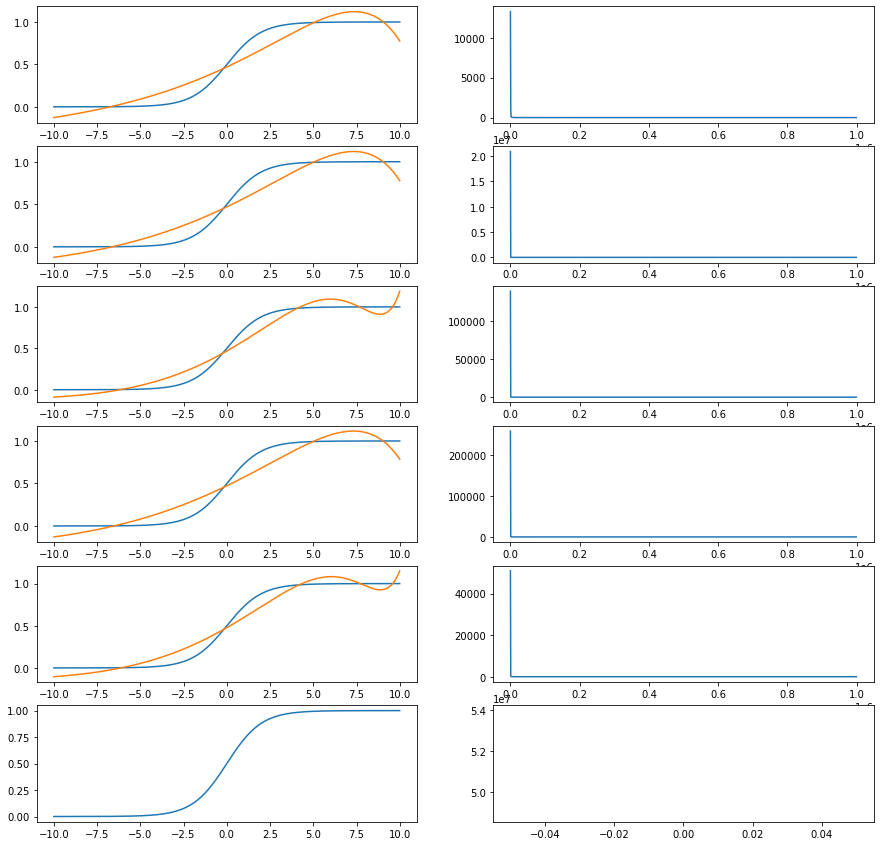

In [32]:
x = np.linspace(-10, 10, 1000) 
y=sigmoid(x)
x=x.reshape(len(x),1)
max_iteration=1000000

weights=[]
vors=[]
losses=[]
fig, ax=plt.subplots(6,2,figsize=(15,15))
for i,n in enumerate([5,6,7,8,9,10]):
    w,v,l=gradient_descent(num_of_exps=n, max_iteration=max_iteration, step_coeff=1e-8)
    weights.append(w.reshape(-1))
    vors.append(v.reshape(-1))
    losses.append(l)
    
    x2=x.reshape(-1)
    y_hat=utility(x2,weights[i],vors[i])
    
    ax[i][0].plot(x2,y)
    ax[i][0].plot(x2,y_hat)
    
    iteration=np.arange(0,max_iteration,1000)
    ls=np.array(losses[i])[iteration]
    ax[i][1].plot(iteration,ls)

In [33]:
weights

[array([ 0.55652885,  0.12756731,  0.37887942, -0.41246709, -0.18061627]),
 array([ 0.22757416,  0.53546187, -0.15532349, -0.44693209, -0.12888231,
         0.43775401]),
 array([-0.04735163,  0.00787612, -0.44363463, -0.32599121,  0.43161067,
         0.41200111,  0.43282371]),
 array([-0.22460195, -0.02868869,  0.31702962, -0.06160155,  0.45053574,
         0.47090178, -0.33851141, -0.11204076]),
 array([-0.35488561,  0.35333981,  0.37551413,  0.01407785,  0.28456508,
        -0.26450835,  0.14129576, -0.54733657,  0.47556711]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])]

In [34]:
vors

[array([ 0.18814835,  0.17674761,  0.19218603,  0.26918572, -0.0368179 ]),
 array([ 0.1742895 ,  0.17718892, -0.0161262 ,  0.26009444,  0.01414744,
         0.17937245]),
 array([0.33802835, 0.66287355, 0.36634322, 0.05424423, 0.24026938,
        0.24683731, 0.24160139]),
 array([0.01233951, 0.05065841, 0.15310408, 0.03182986, 0.15833746,
        0.15863982, 0.26231696, 0.01019507]),
 array([0.0456865 , 0.22985762, 0.22918934, 0.61723759, 0.22973234,
        0.39241081, 0.20600282, 0.26996681, 0.24143137]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])]